Link to the dataset used: https://www.ll.mit.edu/r-d/datasets/vpnnonvpn-network-application-traffic-dataset-vnat

## Creating a script to process PCAP files

In [ ]:
%%writefile pcap_gobbler.sh
#!/bin/bash

if [ "$#" -ne 3 ]; then
    echo "Usage: $0 <input_directory> <output_csv_file> <python_script>"
    exit 1
fi

INPUT_DIR="$1"
OUTPUT_FILE="$2"
PYTHON_SCRIPT="$3"

SCRIPT_DIR="$(dirname "$0")"
TEMP_FILE="$SCRIPT_DIR/temp_output.csv"

if [ ! -f "$PYTHON_SCRIPT" ]; then
    echo "Python script $PYTHON_SCRIPT not found."
    exit 1
fi

if [ -f "$OUTPUT_FILE" ]; then
    rm "$OUTPUT_FILE"
fi

HEADER_WRITTEN=false

if [ ! -d "$INPUT_DIR" ]; then
    echo "Input directory $INPUT_DIR does not exist."
    exit 1
fi

for file in "$INPUT_DIR"/*.pcap; do
    if [ ! -e "$file" ]; then
        echo "No .pcap files found in $INPUT_DIR"
        exit 1
    fi

    echo "Processing $file..."

    python3.9 "$PYTHON_SCRIPT" "$file" "$TEMP_FILE"

    if [ -f "$TEMP_FILE" ]; then
        if [ "$HEADER_WRITTEN" = false ]; then
            cat "$TEMP_FILE" >> "$OUTPUT_FILE"
            HEADER_WRITTEN=true
        else
            tail -n +2 "$TEMP_FILE" >> "$OUTPUT_FILE"
        fi
    fi
done

rm -f "$TEMP_FILE"

echo "All files processed. Combined output is in $OUTPUT_FILE"

## Creating the NFStream python script

In [ ]:
%%writefile nfstream_v1.py
import sys
from nfstream import NFStreamer, NFPlugin

class PayloadFeatures(NFPlugin):
 def __init__(self, length=40):
     super().__init__()
     self.length = length

 def get_payload(self, packet):
     header_size = packet.ip_size - packet.payload_size
     return list(packet.ip_packet[header_size:header_size + packet.payload_size])

 def on_init(self, packet, flow):
     flow.udps.splt_payload = [-1] * self.length
     flow.udps.splt_payload[0] = self.get_payload(packet)
     flow.udps.splt_payload_size = [-1] * self.length
     flow.udps.splt_payload_size[0] = packet.payload_size

 def on_update(self, packet, flow):
     if flow.bidirectional_packets <= self.length:
         packet_index = flow.bidirectional_packets - 1
         flow.udps.splt_payload[packet_index] = self.get_payload(packet)
         flow.udps.splt_payload_size[packet_index] = packet.payload_size

if len(sys.argv) != 3:
    print("Usage: python nfstream.py <pcap_file> <output_csv>")
    sys.exit(1)

pcap_file = sys.argv[1]
output_csv = sys.argv[2]

NFStreamer(
    source=pcap_file,
    decode_tunnels=False,
    n_dissections=20,
    splt_analysis=40,
    statistical_analysis=True,
    accounting_mode=1,
    n_meters=0,
    idle_timeout=120,
    active_timeout=180000,
    udps=PayloadFeatures(length=40)
).to_csv(output_csv)

## Processing PCAP files containing non-VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing non-VPN pcap files' novpn_mit_v1.csv nfstream_v1.py

## Processing PCAP files containing VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing VPN pcap files' vpn_mit_v1.csv nfstream_v1.py

## Reading CSV files, labeling data, concatenating, and filtering

In [6]:
import pandas as pd

novpn = pd.read_csv("novpn_mit_v1.csv")
vpn = pd.read_csv("vpn_mit_v1.csv")

print(novpn.info())
print(vpn.info())

novpn['VPN'] = 'noVPN'
vpn['VPN'] = 'VPN'

df_large = pd.concat([novpn, vpn], ignore_index=True)

print(df_large[['splt_ps', 'udps.splt_payload_size']].iloc[0])
print(df_large['bidirectional_min_piat_ms'].min())

df = df_large[['udps.splt_payload', 'udps.splt_payload_size', 'VPN']]

print(df.info())
print(df['udps.splt_payload'])
print(df['udps.splt_payload_size'])

/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_720/563586274.py:3: DtypeWarning: Columns (83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  novpn = pd.read_csv("novpn_mit_v1.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175664 entries, 0 to 175663
Data columns (total 90 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            175664 non-null  int64  
 1   expiration_id                 175664 non-null  int64  
 2   src_ip                        175664 non-null  object 
 3   src_mac                       175664 non-null  object 
 4   src_oui                       175664 non-null  object 
 5   src_port                      175664 non-null  int64  
 6   dst_ip                        175664 non-null  object 
 7   dst_mac                       175664 non-null  object 
 8   dst_oui                       175664 non-null  object 
 9   dst_port                      175664 non-null  int64  
 10  protocol                      175664 non-null  int64  
 11  ip_version                    175664 non-null  int64  
 12  vlan_id                       175664 non-nul

## Calculating the Sample Entropy Fingerprint (SEF) and flagging suspicious traffic

In [8]:
import numpy as np

def calculate_entropy(window):
    values = np.array(window)

    unique_values, counts = np.unique(values, return_counts=True)

    probs = counts / len(values)

    if len(probs) == 1:
        return 0.0

    entropy = -np.sum(probs * np.log2(probs))
    return entropy

def sample_entropy_fingerprint(data, buf_size, win_size, u, t, sigma):
    payload = data['udps.splt_payload']
    H_f_list = []
    suspicious_flags = []

    for flow_payload in payload:
        payload_list = eval(flow_payload)
        PayloadBuffer = []

        for packet_payload in payload_list:
            if packet_payload != -1:
              for byte in packet_payload:
                PayloadBuffer.append(hex(byte))

            if len(PayloadBuffer) >= buf_size:
              PayloadBuffer = PayloadBuffer[:buf_size]
              break

        H_f = []
        count = 0

        for i in range(len(PayloadBuffer) - win_size):
            win_buffer = PayloadBuffer[i:i + win_size]

            H_i = calculate_entropy(win_buffer)
            H_f.append(H_i)

            if H_i > (u - t * sigma):
                count += 1

        if count > (len(PayloadBuffer) - win_size + 1) * 0.995:
            suspicious_flags.append('VPN')
        else:
            suspicious_flags.append('noVPN')

        H_f_list.append(H_f)

    return H_f_list, suspicious_flags

buf_size = 256
win_size = 32

u = 4.8817
t = 3
sigma = 0.08134

H_f_list, suspicious_flags = sample_entropy_fingerprint(df, buf_size, win_size, u, t, sigma)

df['entropy_fingerprint'] = H_f_list
df['suspicious_flags'] = suspicious_flags

/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_720/2850525499.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entropy_fingerprint'] = H_f_list
/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_720/2850525499.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['suspicious_flags'] = suspicious_flags


## Visualizing SEF between VPN and noVPN traffic

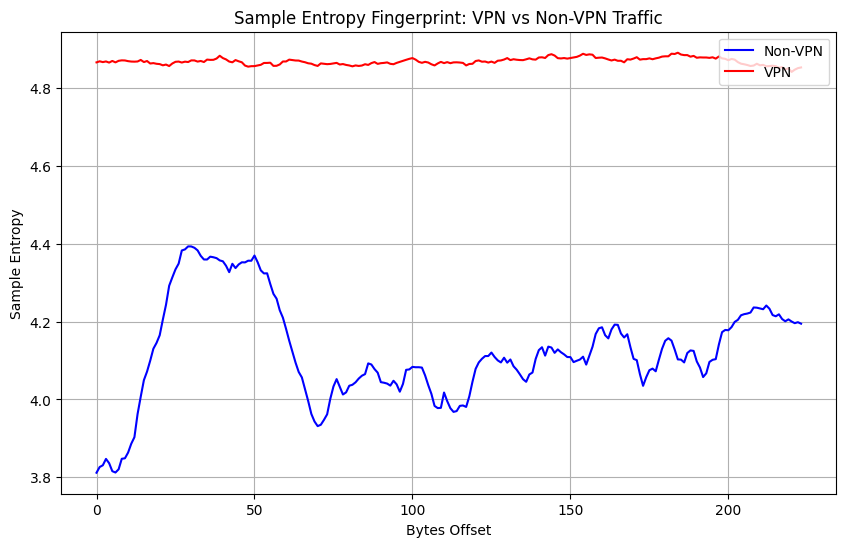

VPN entropy range: 4.842208029630527 to 4.891551422989461
Non-VPN entropy range: 3.8116949940815164 to 4.393615640004123
Mean (u): 4.1399207833646345
Standard Deviation (sigma): 0.6746088621147996
Threshold (1st percentile): 0.3372900666170139
t: 5.636793303940497


In [9]:
import numpy as np
import matplotlib.pyplot as plt

min_required_length = 224

vpn_fingerprints_filtered = [fp for fp in df[df['VPN'] == 'VPN']['entropy_fingerprint'].to_numpy() if len(fp) >= min_required_length]
non_vpn_fingerprints_filtered = [fp for fp in df[df['VPN'] == 'noVPN']['entropy_fingerprint'].to_numpy() if len(fp) >= min_required_length]

vpn_fingerprints_truncated = [fp[:min_required_length] for fp in vpn_fingerprints_filtered]
non_vpn_fingerprints_truncated = [fp[:min_required_length] for fp in non_vpn_fingerprints_filtered]

mean_vpn_entropy = np.mean(vpn_fingerprints_truncated, axis=0)
mean_non_vpn_entropy = np.mean(non_vpn_fingerprints_truncated, axis=0)

plt.figure(figsize=(10, 6))
x_axis = np.arange(min_required_length)

plt.plot(x_axis, mean_non_vpn_entropy, label="Non-VPN", color="blue")
plt.plot(x_axis, mean_vpn_entropy, label="VPN", color="red")

plt.xlabel('Bytes Offset')
plt.ylabel('Sample Entropy')
plt.title('Sample Entropy Fingerprint: VPN vs Non-VPN Traffic')
plt.legend(loc='upper right')

plt.grid(True)
plt.show()

print(f"VPN entropy range: {np.min(mean_vpn_entropy)} to {np.max(mean_vpn_entropy)}")
print(f"Non-VPN entropy range: {np.min(mean_non_vpn_entropy)} to {np.max(mean_non_vpn_entropy)}")

all_entropy_samples = vpn_fingerprints_truncated + non_vpn_fingerprints_truncated
entropy_array = np.array(all_entropy_samples)

u = np.mean(entropy_array)
sigma = np.std(entropy_array)
threshold = np.percentile(entropy_array, 1)
t = (u - threshold) / sigma

print(f"Mean (u): {u}")
print(f"Standard Deviation (sigma): {sigma}")
print(f"Threshold (1st percentile): {threshold}")
print(f"t: {t}")

## Classification metrics and confusion matrix for VPN vs noVPN flagged by SEF

              precision    recall  f1-score   support

         VPN       0.34      0.81      0.48        85
       noVPN       1.00      1.00      1.00    175125

    accuracy                           1.00    175210
   macro avg       0.67      0.91      0.74    175210
weighted avg       1.00      1.00      1.00    175210



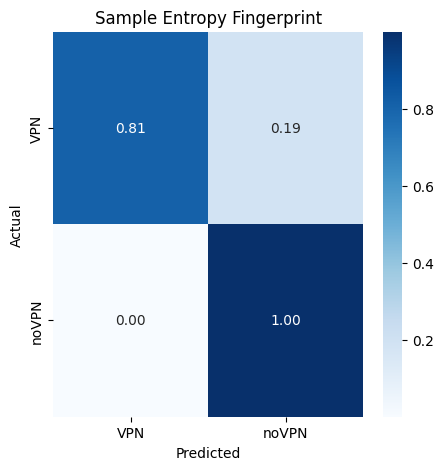

VPN
noVPN    175125
VPN          85
Name: count, dtype: int64
suspicious_flags
noVPN    175006
VPN         204
Name: count, dtype: int64


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df['entropy_fingerprint'].apply(len) > 0]
df = df.reset_index(drop=True)

sef_report = classification_report(df['VPN'], df['suspicious_flags'], output_dict=True)
print(classification_report(df['VPN'], df['suspicious_flags']))

cm = confusion_matrix(df['VPN'], df['suspicious_flags'], normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['VPN', 'noVPN'], yticklabels=['VPN', 'noVPN'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Sample Entropy Fingerprint')
plt.show()

print(df['VPN'].value_counts())
print(df['suspicious_flags'].value_counts())

## Examining SEF list truncations to achieve better accuracy

In [11]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

def truncate_list(x, min_len, max_len):
    return x[min_len:max_len]

truncation_lengths = range(0, 51, 10)

best_accuracy = 0
best_length_combination = (0, 0)

df_dropped = df[df['entropy_fingerprint'].apply(len) > 0]
df_dropped = df_dropped.reset_index(drop=True)
print(df_dropped['VPN'].value_counts())

for min_len in truncation_lengths:
    for max_len in range(min_len + 10, 51, 10):
        df_using = df_dropped.copy(deep=True)
        df_using['entropy_fingerprint'] = df_dropped['entropy_fingerprint'].apply(lambda x: truncate_list(x, min_len, max_len))
        
        df_fingerprints = pd.DataFrame(df_using['entropy_fingerprint'].tolist()).fillna(0)
    
        pca = PCA(n_components=0.95)
        reduced_fingerprints = pd.DataFrame(pca.fit_transform(df_fingerprints))
    
        le = LabelEncoder()
        df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

        new_columns = [f'SEF_{i+1}' for i in range(len(reduced_fingerprints.columns))]
        reduced_fingerprints.columns = new_columns
        sef_columns = new_columns + ['suspicious_flags']
    
        df_entropy = pd.concat([df_using, reduced_fingerprints], axis=1)
        
        X = df_entropy[new_columns]
        y = df_entropy['label_encoded']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Min Length: {min_len}, Max Length: {max_len}, Accuracy: {accuracy:.4f}")
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_length_combination = (min_len, max_len)

print(f"\nBest Min Length: {best_length_combination[0]}, Best Max Length: {best_length_combination[1]}, Best Accuracy: {best_accuracy:.4f}")

VPN
noVPN    175125
VPN          85
Name: count, dtype: int64
Min Length: 0, Max Length: 10, Accuracy: 0.9995
Min Length: 0, Max Length: 20, Accuracy: 0.9995
Min Length: 0, Max Length: 30, Accuracy: 0.9995
Min Length: 0, Max Length: 40, Accuracy: 0.9995
Min Length: 0, Max Length: 50, Accuracy: 0.9995
Min Length: 10, Max Length: 20, Accuracy: 0.9995
Min Length: 10, Max Length: 30, Accuracy: 0.9995
Min Length: 10, Max Length: 40, Accuracy: 0.9995
Min Length: 10, Max Length: 50, Accuracy: 0.9995
Min Length: 20, Max Length: 30, Accuracy: 0.9995
Min Length: 20, Max Length: 40, Accuracy: 0.9995
Min Length: 20, Max Length: 50, Accuracy: 0.9995
Min Length: 30, Max Length: 40, Accuracy: 0.9995
Min Length: 30, Max Length: 50, Accuracy: 0.9993
Min Length: 40, Max Length: 50, Accuracy: 0.9995

Best Min Length: 0, Best Max Length: 10, Best Accuracy: 0.9995


## Applying the best truncation and processing SEF values using Principal Component Analysis (PCA)

In [12]:
from sklearn.decomposition import PCA

def truncate_list(x, min_len, max_len):
    return x[min_len:max_len]

best_length_combination = (0, 40)

df_dropped = df[df['entropy_fingerprint'].apply(len) > 0]
df_dropped = df_dropped.reset_index(drop=True)
df_dropped['entropy_fingerprint'] = df_dropped['entropy_fingerprint'].apply(lambda x: truncate_list(x, best_length_combination[0], best_length_combination[1]))

df_fingerprints = pd.DataFrame(df_dropped['entropy_fingerprint'].tolist()).fillna(0)
pca = PCA(n_components=0.95)
reduced_fingerprints = pd.DataFrame(pca.fit_transform(df_fingerprints))

new_columns = [f'SEF_{i+1}' for i in range(len(reduced_fingerprints.columns))]
reduced_fingerprints.columns = new_columns
sef_columns = new_columns + ['suspicious_flags']

df_entropy = pd.concat([df_dropped, reduced_fingerprints], axis=1).fillna(0)
df_entropy = df_entropy.reset_index(drop=True)
print(df_entropy.info())
print(df_entropy['VPN'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175210 entries, 0 to 175209
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   udps.splt_payload       175210 non-null  object 
 1   udps.splt_payload_size  175210 non-null  object 
 2   VPN                     175210 non-null  object 
 3   entropy_fingerprint     175210 non-null  object 
 4   suspicious_flags        175210 non-null  object 
 5   SEF_1                   175210 non-null  float64
 6   SEF_2                   175210 non-null  float64
 7   SEF_3                   175210 non-null  float64
dtypes: float64(3), object(5)
memory usage: 10.7+ MB
None
VPN
noVPN    175125
VPN          85
Name: count, dtype: int64


## Finding the dataset values of the first N packets with the best accuracy

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

def extract_values(string_array, n_values):
    array_list = eval(string_array)
    filtered_values = [x for x in array_list if x not in (0, -1)]
    values = filtered_values[:n_values]
    if len(values) < n_values:
        values.extend([-1] * (n_values - len(values)))

    return pd.Series(values, index=[f'PLS_{i+1}' for i in range(n_values)])

best_accuracy = 0
best_n_values = 0

for n_values in range(3, 11):
    
    new_columns = df_dropped['udps.splt_payload_size'].apply(lambda x: extract_values(x, n_values))
    df_packets = pd.concat([df_entropy, new_columns], axis=1).dropna()

    le = LabelEncoder()
    df_packets['label_encoded'] = le.fit_transform(df_packets['VPN'])
    
    X = df_packets[new_columns.columns]
    y = df_packets['label_encoded']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Number of Extracted Values: {n_values}, Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_values = n_values

print(f"\nBest Number of Extracted Values: {best_n_values}, Best Accuracy: {best_accuracy:.4f}")

Number of Extracted Values: 3, Accuracy: 0.9999
Number of Extracted Values: 4, Accuracy: 0.9999
Number of Extracted Values: 5, Accuracy: 1.0000
Number of Extracted Values: 6, Accuracy: 1.0000
Number of Extracted Values: 7, Accuracy: 1.0000
Number of Extracted Values: 8, Accuracy: 1.0000
Number of Extracted Values: 9, Accuracy: 1.0000
Number of Extracted Values: 10, Accuracy: 1.0000

Best Number of Extracted Values: 5, Best Accuracy: 1.0000


## Loading the first N packets with the best accuracy into the dataset

In [14]:
new_columns = df_dropped['udps.splt_payload_size'].apply(lambda x: extract_values(x, 4))

df_packets = pd.concat([df_entropy, new_columns], axis=1).dropna()
df_packets = df_packets.reset_index(drop=True)

print(df_packets.info())
print(df_packets['VPN'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175210 entries, 0 to 175209
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   udps.splt_payload       175210 non-null  object 
 1   udps.splt_payload_size  175210 non-null  object 
 2   VPN                     175210 non-null  object 
 3   entropy_fingerprint     175210 non-null  object 
 4   suspicious_flags        175210 non-null  object 
 5   SEF_1                   175210 non-null  float64
 6   SEF_2                   175210 non-null  float64
 7   SEF_3                   175210 non-null  float64
 8   PLS_1                   175210 non-null  int64  
 9   PLS_2                   175210 non-null  int64  
 10  PLS_3                   175210 non-null  int64  
 11  PLS_4                   175210 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 16.0+ MB
None
VPN
noVPN    175125
VPN          85
Name: count, dtype: int64


## Creating three types of datasets, optionally encoding labels for the values

In [15]:
from sklearn.preprocessing import LabelEncoder

df_sef = df_entropy.drop(['udps.splt_payload', 'udps.splt_payload_size', 'entropy_fingerprint'], axis=1)
df_pls = df_packets.drop(['udps.splt_payload', 'udps.splt_payload_size', 'entropy_fingerprint'] + sef_columns, axis=1)
df_both = df_packets.drop(['udps.splt_payload', 'udps.splt_payload_size', 'entropy_fingerprint'], axis=1)

le = LabelEncoder()
df_sef['encoded_flags'] = le.fit_transform(df_sef['suspicious_flags'])
df_both['encoded_flags'] = le.fit_transform(df_both['suspicious_flags'])

## Decision Tree (SEF, PLS, SEF+PLS)

Train Accuracy: 1.0
Validation Accuracy: 0.9993436447691342
              precision    recall  f1-score   support

         VPN       0.36      0.47      0.41        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.68      0.74      0.70     35042
weighted avg       1.00      1.00      1.00     35042



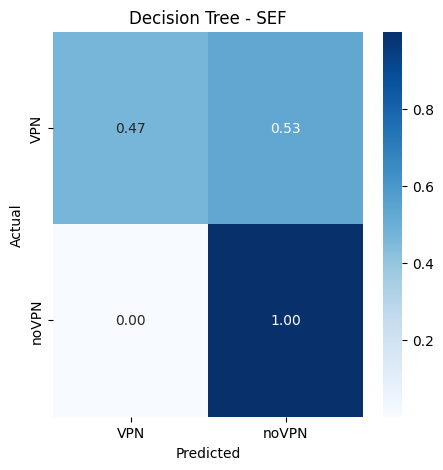

0.999914388448148
{'precision': 0.9444301685193645, 'recall': 0.9705596842591426, 'f1-score': 0.9571214435609359, 'support': 35042.0}
Train Accuracy: 1.0
Validation Accuracy: 0.999914388448148
              precision    recall  f1-score   support

         VPN       0.94      0.88      0.91        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.97      0.94      0.95     35042
weighted avg       1.00      1.00      1.00     35042



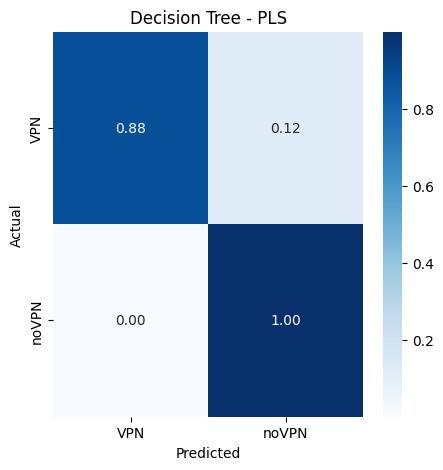

0.999914388448148
{'precision': 0.9444301685193645, 'recall': 0.9705596842591426, 'f1-score': 0.9571214435609359, 'support': 35042.0}
Train Accuracy: 1.0
Validation Accuracy: 0.999914388448148
              precision    recall  f1-score   support

         VPN       0.89      0.94      0.91        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.94      0.97      0.96     35042
weighted avg       1.00      1.00      1.00     35042



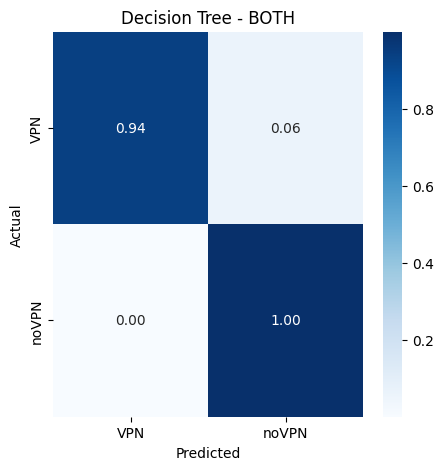

0.999914388448148
{'precision': 0.9444301685193645, 'recall': 0.9705596842591426, 'f1-score': 0.9571214435609359, 'support': 35042.0}


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# SEF
df_using = df_sef.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded', 'suspicious_flags'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report_sef = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree - SEF')
plt.show()

print(dt_report['accuracy'])
print(dt_report['macro avg'])

# PLS
df_using = df_pls.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report_pls = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree - PLS')
plt.show()

print(dt_report['accuracy'])
print(dt_report['macro avg'])

# SEF+PLS
df_using = df_both.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded', 'suspicious_flags'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report_both = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree - BOTH')
plt.show()

print(dt_report['accuracy'])
print(dt_report['macro avg'])

## Random Forest (SEF, PLS, SEF+PLS)

Train Accuracy: 1.0
Validation Accuracy: 0.9994577935049369
              precision    recall  f1-score   support

         VPN       0.38      0.18      0.24        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.69      0.59      0.62     35042
weighted avg       1.00      1.00      1.00     35042



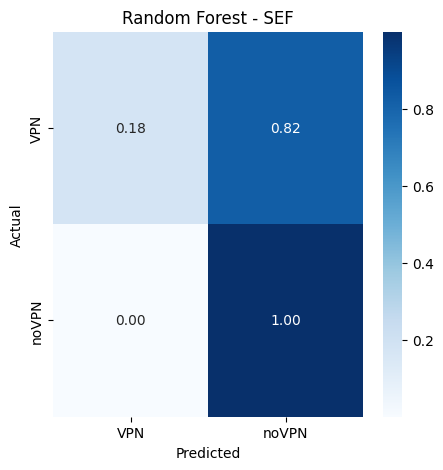

1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35042.0}
Train Accuracy: 1.0
Validation Accuracy: 1.0
              precision    recall  f1-score   support

         VPN       1.00      1.00      1.00        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       1.00      1.00      1.00     35042
weighted avg       1.00      1.00      1.00     35042



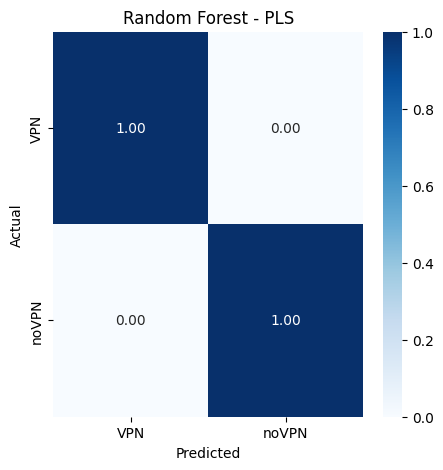

1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35042.0}
Train Accuracy: 1.0
Validation Accuracy: 1.0
              precision    recall  f1-score   support

         VPN       1.00      1.00      1.00        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       1.00      1.00      1.00     35042
weighted avg       1.00      1.00      1.00     35042



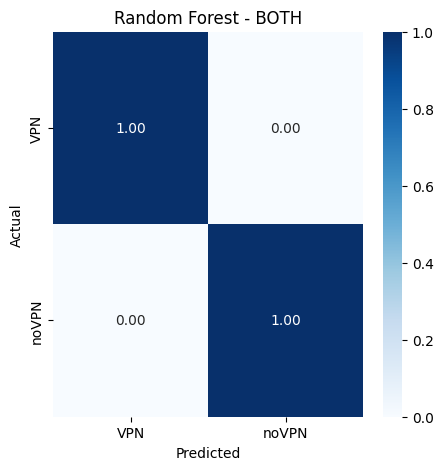

1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35042.0}


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# SEF
df_using = df_sef.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded', 'suspicious_flags'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report_sef = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest - SEF')
plt.show()

print(rf_report['accuracy'])
print(rf_report['macro avg'])

# PLS
df_using = df_pls.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report_pls = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest - PLS')
plt.show()

print(rf_report['accuracy'])
print(rf_report['macro avg'])

# SEF+PLS
df_using = df_both.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded', 'suspicious_flags'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report_both = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest - BOTH')
plt.show()

print(rf_report['accuracy'])
print(rf_report['macro avg'])

## Neural Network (SEF, PLS, SEF+PLS)

Epoch 1/20


/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9994 - loss: 0.0198 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 2/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 3/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 4/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 5/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 6/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 7/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 8/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accu

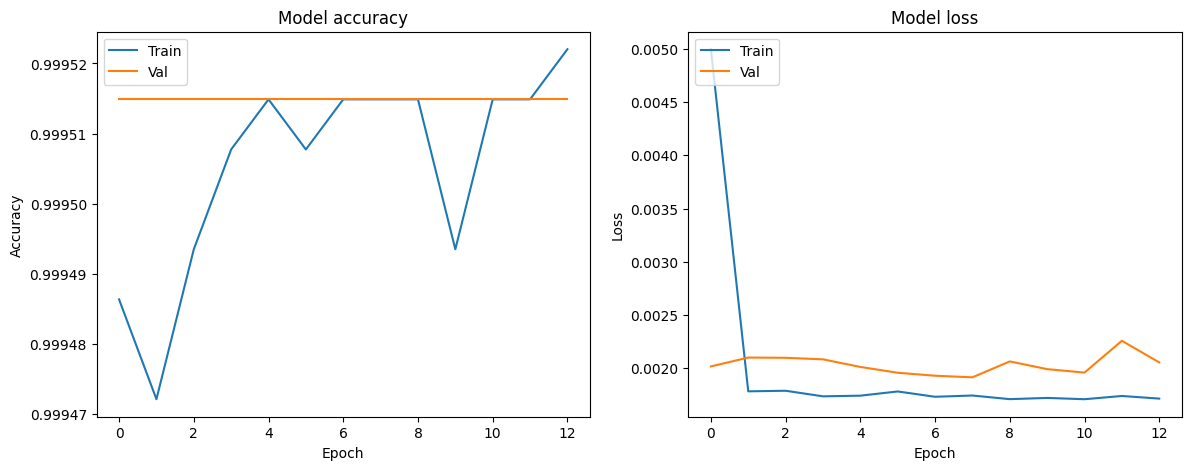

Train Accuracy: 0.9995220303535461
Validation Accuracy: 0.9995148777961731
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

         VPN       0.00      0.00      0.00        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.50      0.50      0.50     35042
weighted avg       1.00      1.00      1.00     35042



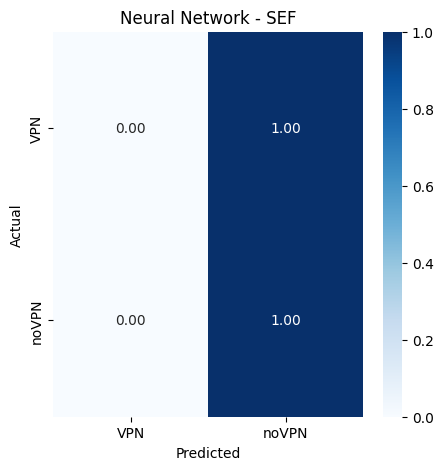

0.9995148678728383
{'precision': 0.49975743393641914, 'recall': 0.5, 'f1-score': 0.49987868754192416, 'support': 35042.0}
Epoch 1/20


/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4381/4381 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9977 - loss: 0.0359 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 2/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 3/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 0.0017
Epoch 4/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 5/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 6/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 9.4096e-04 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 7/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 8/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 9.2694e-04 - v

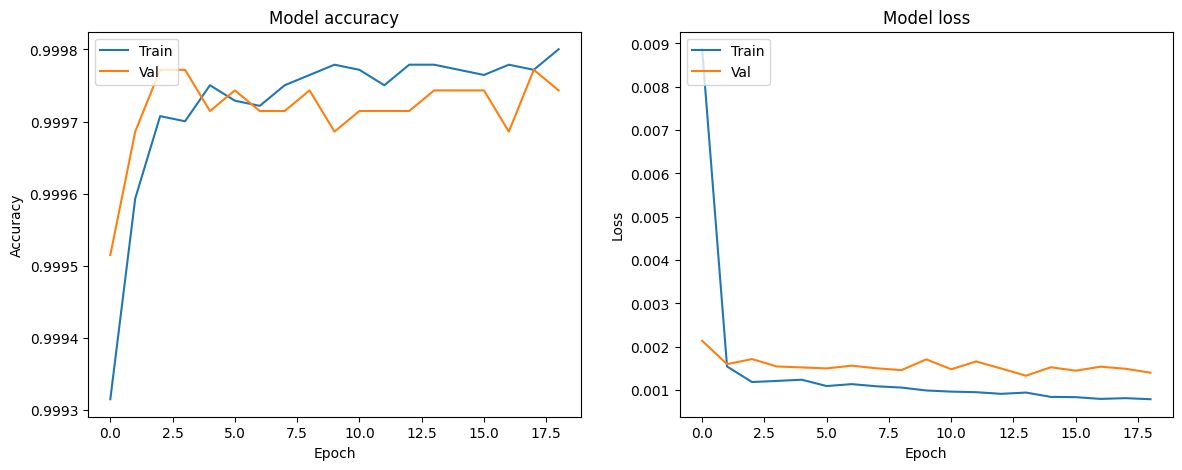

Train Accuracy: 0.9998002648353577
Validation Accuracy: 0.9997431635856628
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         VPN       0.90      0.53      0.67        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.95      0.76      0.83     35042
weighted avg       1.00      1.00      1.00     35042



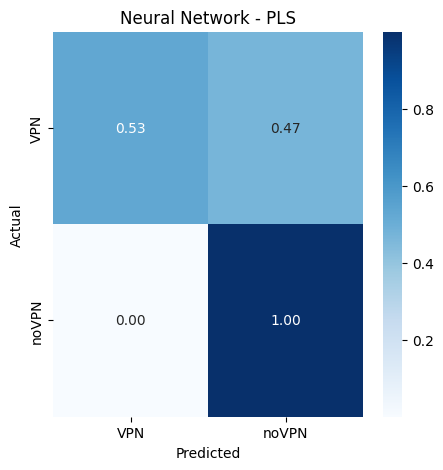

0.9997431653444439
{'precision': 0.9498858186800639, 'recall': 0.7646916068354537, 'f1-score': 0.8332690999233957, 'support': 35042.0}
Epoch 1/20


/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4381/4381 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9995 - loss: 0.0131 - val_accuracy: 0.9997 - val_loss: 0.0018
Epoch 2/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 3/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 8.3576e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 4/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 8.1339e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 5/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss: 8.7745e-04 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 6/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9998 - loss: 6.5443e-04 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 7/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss: 8.0519e-04 - val_accuracy: 0.9998 - val_loss: 9.8539e-04
Epoch 8/20
4381/4381 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9998 

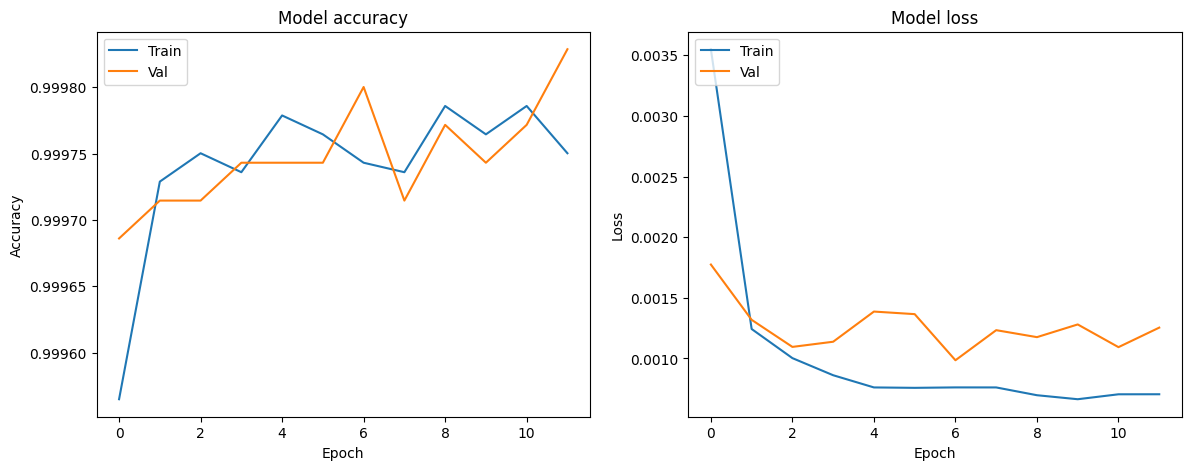

Train Accuracy: 0.9997503161430359
Validation Accuracy: 0.9998287558555603
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         VPN       0.87      0.76      0.81        17
       noVPN       1.00      1.00      1.00     35025

    accuracy                           1.00     35042
   macro avg       0.93      0.88      0.91     35042
weighted avg       1.00      1.00      1.00     35042



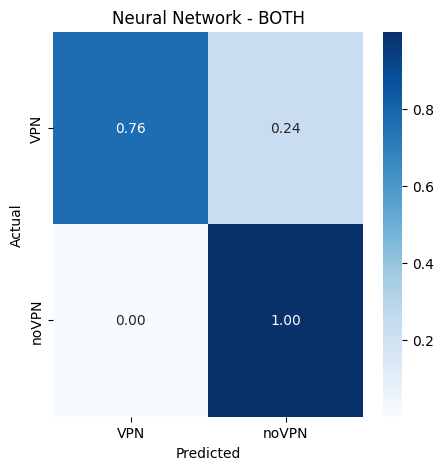

0.9998287768962959
{'precision': 0.9332762345238435, 'recall': 0.8823243901414956, 'f1-score': 0.9062071746702449, 'support': 35042.0}


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SEF
df_using = df_sef.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN', 'suspicious_flags'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report_sef = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Neural Network - SEF')
plt.show()

print(nn_report_sef['accuracy'])
print(nn_report_sef['macro avg'])

# PLS
df_using = df_pls.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with one neuron per class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report_pls = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Neural Network - PLS')
plt.show()

print(nn_report_pls['accuracy'])
print(nn_report_pls['macro avg'])

# SEF+PLS
df_using = df_both.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN', 'suspicious_flags'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report_both = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Neural Network - BOTH')
plt.show()

print(nn_report_both['accuracy'])
print(nn_report_both['macro avg'])

## Concatenating and writing out macro average data

In [23]:
from IPython.display import display

macro_avg_data = sef_report['macro avg']

df_macro_avg = pd.DataFrame.from_dict(macro_avg_data, orient='index').transpose()

df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(dt_report_sef['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report_sef['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report_sef['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(dt_report_pls['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report_pls['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report_pls['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(dt_report_both['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report_both['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report_both['macro avg'], index=[0])], ignore_index=True)

accuracy_column = [sef_report['accuracy'], dt_report_sef['accuracy'], rf_report_sef['accuracy'], nn_report_sef['accuracy'], 
                   dt_report_pls['accuracy'], rf_report_pls['accuracy'], nn_report_pls['accuracy'], 
                   dt_report_both['accuracy'], rf_report_both['accuracy'], nn_report_both['accuracy']]
df_accuracy = pd.DataFrame({'accuracy': accuracy_column})
df_macro_avg = pd.concat([df_accuracy, df_macro_avg], axis=1)

model_column = ['SEF_Raw', 'SEF_DT', 'SEF_RF', 'SEF_NN', 'PLS_DT', 'PLS_RF', 'PLS_NN', 'BOTH_DT', 'BOTH_RF', 'BOTH_NN']
df_model = pd.DataFrame({'model': model_column})
df_macro_avg = pd.concat([df_model, df_macro_avg], axis=1)

df_macro_avg = df_macro_avg.drop(columns='support', axis=1)

display(df_macro_avg)

,model,accuracy,precision,recall,f1-score
0,SEF_Raw,0.999138,0.669072,0.905497,0.738539
1,SEF_DT,0.999344,0.681690,0.735094,0.704964
2,SEF_RF,0.999458,0.687300,0.588164,0.619864
3,SEF_NN,0.999515,0.499757,0.500000,0.499879
4,PLS_DT,0.999914,0.968721,0.941162,0.954524
5,PLS_RF,1.000000,1.000000,1.000000,1.000000
6,PLS_NN,0.999743,0.949886,0.764692,0.833269
7,BOTH_DT,0.999914,0.944430,0.970560,0.957121
8,BOTH_RF,1.000000,1.000000,1.000000,1.000000
9,BOTH_NN,0.999829,0.933276,0.882324,0.906207
